In [15]:
import numpy as np
from qutip import Options
import qutip as qt
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.hamiltonian import QubitQubitCavity
from quantum_logical.pulsesim.mode import QubitMode, CavityMode
import matplotlib.pyplot as plt

opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()  # None

In [16]:
# Optionally, can build from a YAML file instead :)
# quantum_system = QuantumSystem.from_yaml(yaml_file)

# TODO
# FIXME, these kwargs attributes are ugly/bad :(
qubit1 = QubitMode(
    mode_type="Qubit", name="q1", dim=2, freq=2.75, alpha=-0.1, T1=1e3, T2=5e3
)
qubit2 = QubitMode(
    mode_type="Qubit", name="q2", dim=2, freq=3.25, alpha=-0.1, T1=1e3, T2=5e3
)
cavity = CavityMode(mode_type="Cavity", name="c", dim=2, freq=5.0, T1=1e3, T2=1.5e3)
_couplings = {
    (qubit1, cavity): 2 * np.pi * 0.0125,
    (qubit2, cavity): 2 * np.pi * 0.0875,
}

quantum_system = QuantumSystem([qubit1, qubit2, cavity], couplings=_couplings)

In [17]:
hamiltonian = QubitQubitCavity(quantum_system)
# hamiltonian.H + sum(hamiltonian._H_int())  # full hamiltonian
hamiltonian.H  # non-interacting hamiltonian

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[-18.84955592   0.           0.           0.           0.
    0.           0.           0.        ]
 [  0.          12.56637061   0.           0.           0.
    0.           0.           0.        ]
 [  0.           0.           1.57079633   0.           0.
    0.           0.           0.        ]
 [  0.           0.           0.          32.98672286   0.
    0.           0.           0.        ]
 [  0.           0.           0.           0.          -1.57079633
    0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
   29.84513021   0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.          18.84955592   0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.          50.26548246]]

In [18]:
# prepare an initial state
psi0 = quantum_system.prepare_tensor_fock_state([(qubit2, 1)])

# prepare qubit bell state tensored with cavity in vacuum state
# psi0 = qt.tensor(qt.bell_state("01"), qt.basis(cavity.dim, 0))

# prepare an inital state |01> for qubits and a slight excitation in the cavity
# |cavity> = .99 |0> + .1 |1>
# psi0 = qt.tensor(
#     qt.basis(qubit1.dim, 0),
#     qt.basis(qubit2.dim, 1),
#     0.99 * qt.basis(cavity.dim, 0) + 0.1 * qt.basis(cavity.dim, 1),
# )

In [19]:
# define desired unitary and expected final state
U = qt.tensor(qt.qip.operations.iswap(N=2), qt.identity(cavity.dim))
expected_psi = U * psi0

In [20]:
# collapse operators
c_ops = []
for mode in quantum_system.modes:
    c_ops.append(mode.collapse_operators(quantum_system))

# NOTE uncomment to turn off loss
# c_ops = None

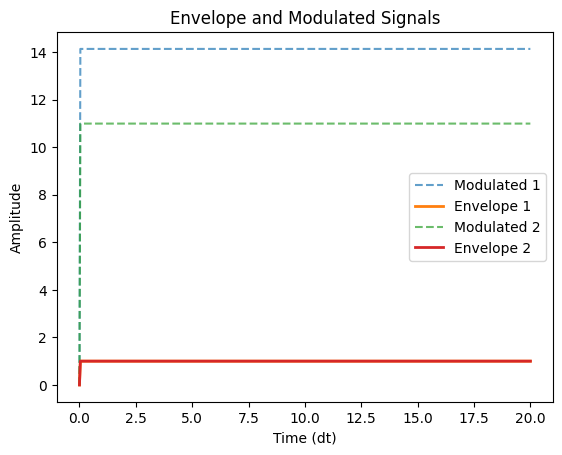

In [21]:
total_pulse_duration = 20
t_list = np.linspace(0, total_pulse_duration, 500)

# in this experiment, we have fixed with and sweep the two amplitudes
width_d = total_pulse_duration

args1 = {"shape": Pulse.box, "shape_params": {"t0": 0, "width": width_d}}
pulse1 = Pulse(omega=0.0, amp=np.abs(qubit1.freq - cavity.freq))
lambda_pulse1 = lambda t, args: pulse1.drive(t, args1)  # noqa: E731

args2 = {"shape": Pulse.box, "shape_params": {"t0": 0, "width": width_d}}
pulse2 = Pulse(omega=0.0, amp=np.abs(qubit2.freq - cavity.freq))
lambda_pulse2 = lambda t, args: pulse2.drive(t, args2)  # noqa: E731

# plot an example pulse from the experiment to verify its shape

Pulse.plot_pulse([(pulse1, args1), (pulse2, args2)], t_list)

In [22]:
# Define experiment constants
N = 30  # Number of points in the parameter sweep

# Sweep pulse amplitudes for both qubits
max_amplitude = 10
amp1_range = np.linspace(0, max_amplitude, N)
amp2_range = np.linspace(0, max_amplitude, N)


def simulation_task(amp1_amp2_tuple):
    amp1, amp2 = amp1_amp2_tuple
    # XXX For now, assuming same pulse for both qubits
    pulse1.amp = amp1
    lambda_pulse1 = lambda t, args: pulse1.drive(t, args1)  # noqa: E731

    pulse2.amp = amp2
    lambda_pulse2 = lambda t, args: pulse2.drive(t, args2)  # noqa: E731

    H = hamiltonian.driven(lambda_pulse1, lambda_pulse2)
    solve_result = qt.mesolve(H, psi0, t_list, options=opts, c_ops=c_ops)

    final_state = solve_result.states[-1]
    ground_state_populations = [
        quantum_system.mode_population_expectation(final_state, mode, 0)
        for mode in quantum_system.modes
    ]

    # Calculate fidelity with the expected final state
    fidelity = qt.fidelity(expected_psi, final_state)

    return ground_state_populations, fidelity


# Prepare the parameters for parallel execution
amp1_amp2_tuple = [(amp1, amp2) for amp1 in amp1_range for amp2 in amp2_range]

# Run the simulations in parallel
results = qt.parallel.parallel_map(simulation_task, amp1_amp2_tuple, progress_bar=True)

# Process results
ground_state_populations = np.zeros(
    (len(quantum_system.modes), len(amp1_range), len(amp2_range))
)
fidelity_matrix = np.zeros((len(amp1_range), len(amp2_range)))

for idx, (amp1, amp2) in enumerate(amp1_amp2_tuple):
    amp2_idx = np.where(amp2_range == amp2)[0][0]
    amp1_idx = np.where(amp1_range == amp1)[0][0]
    populations, fidelity = results[idx]

    # Store ground state populations
    for k, pop in enumerate(populations):
        ground_state_populations[k, amp1_idx, amp2_idx] = pop

    # Store fidelity
    fidelity_matrix[amp1_idx, amp2_idx] = fidelity

10.0%. Run time:   1.86s. Est. time left: 00:00:00:16
20.0%. Run time:   3.22s. Est. time left: 00:00:00:12
30.0%. Run time:   4.66s. Est. time left: 00:00:00:10
40.0%. Run time:   5.89s. Est. time left: 00:00:00:08
50.0%. Run time:   7.08s. Est. time left: 00:00:00:07
60.0%. Run time:   8.55s. Est. time left: 00:00:00:05
70.0%. Run time:  10.04s. Est. time left: 00:00:00:04
80.0%. Run time:  11.30s. Est. time left: 00:00:00:02
90.0%. Run time:  12.52s. Est. time left: 00:00:00:01
100.0%. Run time:  14.02s. Est. time left: 00:00:00:00
Total run time:  14.03s


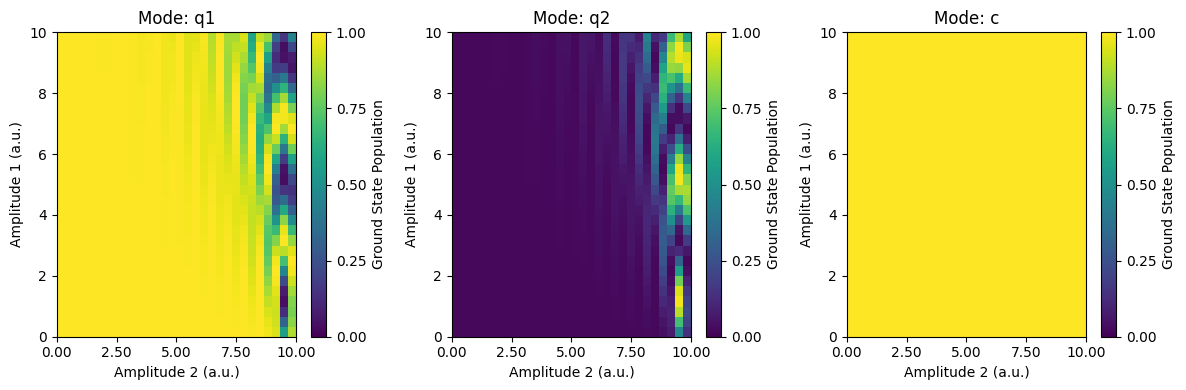

In [23]:
# Prepare the plot
fig, axes = plt.subplots(
    1, len(quantum_system.modes), figsize=(len(quantum_system.modes) * 4, 4)
)

# Define the number of ticks for the detuning x-axis
n_xticks = 5  # Adjust the number of ticks as needed

# Plot data for each mode
for k, mode in enumerate(quantum_system.modes):
    im = axes[k].imshow(
        ground_state_populations[k],
        extent=[amp2_range[0], amp2_range[-1], amp1_range[0], amp1_range[-1]],
        aspect="auto",
        origin="lower",
        vmin=0.0,
        vmax=1.0,  # Set color bar scale from 0.0 to 1.0
    )
    axes[k].set_title(f"Mode: {mode.name}")
    axes[k].set_xlabel("Amplitude 2 (a.u.)")
    axes[k].set_ylabel("Amplitude 1 (a.u.)")

    # Customize x-axis ticks
    # xticks = np.linspace(flist[0] * rad_to_GHz, flist[-1] * rad_to_GHz, n_xticks)
    xticks = np.linspace(amp2_range[0], amp2_range[-1], n_xticks)
    axes[k].set_xticks(xticks)
    axes[k].set_xticklabels([f"{x:.2f}" for x in xticks])  # Format the tick labels

    # Add color bar
    cbar = fig.colorbar(
        im, ax=axes[k], orientation="vertical", label="Ground State Population"
    )
    cbar.set_ticks(np.linspace(0, 1, 5))  # Customize color bar ticks

plt.tight_layout()
plt.show()

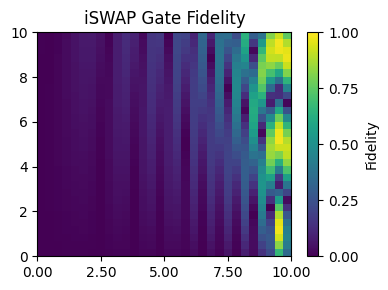

In [24]:
# Prepare the plot for fidelity
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the fidelity matrix
im = ax.imshow(
    fidelity_matrix,
    extent=[amp2_range[0], amp2_range[-1], amp1_range[0], amp1_range[-1]],
    aspect="auto",
    origin="lower",
    vmin=0.0,
    vmax=1.0,  # Fidelity ranges from 0 to 1
)

ax.set_title("iSWAP Gate Fidelity")
axes[k].set_xlabel("Amplitude 2 (a.u.)")
axes[k].set_ylabel("Amplitude 1 (a.u.)")
ax.set_xticks(np.linspace(amp2_range[0], amp2_range[-1], n_xticks))
ax.set_xticklabels(
    [f"{x:.2f}" for x in np.linspace(amp2_range[0], amp2_range[-1], n_xticks)]
)

# Add color bar for fidelity
cbar = fig.colorbar(im, ax=ax, orientation="vertical", label="Fidelity")
cbar.set_ticks(np.linspace(0, 1, 5))

plt.tight_layout()
plt.show()

In [25]:
# Find the pulse parameters that maximize fidelity
max_fidelity = np.max(fidelity_matrix)
max_fidelity_indices = np.where(fidelity_matrix == max_fidelity)

# Since the indices are returned in a tuple of arrays, we take the first element
max_fidelity_amp_idx, max_fidelity_width_idx = (
    max_fidelity_indices[0][0],
    max_fidelity_indices[1][0],
)

# Retrieve the amplitude and width that correspond to the maximum fidelity
max_fidelity_amp2 = amp2_range[max_fidelity_width_idx]
max_fidelity_amp1 = amp1_range[max_fidelity_amp_idx]

print(f"Max fidelity: {max_fidelity:.4f}")
print(f"Pulse 2 amplitude for max fidelity: {max_fidelity_amp2:.2f} a.u.")
print(f"Pulse 1 amplitude for max fidelity: {max_fidelity_amp1:.2f} a.u.")

Max fidelity: 0.9813
Pulse 2 amplitude for max fidelity: 9.66 a.u.
Pulse 1 amplitude for max fidelity: 5.17 a.u.


In [26]:
# set the calibrated width and amplitude
pulse1.amp = max_fidelity_amp1
pulse2.amp = max_fidelity_amp2
lambda_pulse1 = lambda t, args: pulse1.drive(t, args1)  # noqa: E731

lambda_pulse2 = lambda t, args: pulse2.drive(t, args2)  # noqa: E731
H = hamiltonian.driven(lambda_pulse1, lambda_pulse2)

e_ops = e_ops = [quantum_system.modes_num[m] for m in quantum_system.modes]
solve_result = qt.mesolve(
    H,
    psi0,
    t_list,
    e_ops=e_ops,
    progress_bar=p_bar,
    c_ops=c_ops,
)

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.02s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
70.0%. Run time:   0.03s. Est. time left: 00:00:00:00
80.0%. Run time:   0.03s. Est. time left: 00:00:00:00
90.0%. Run time:   0.04s. Est. time left: 00:00:00:00
Total run time:   0.04s


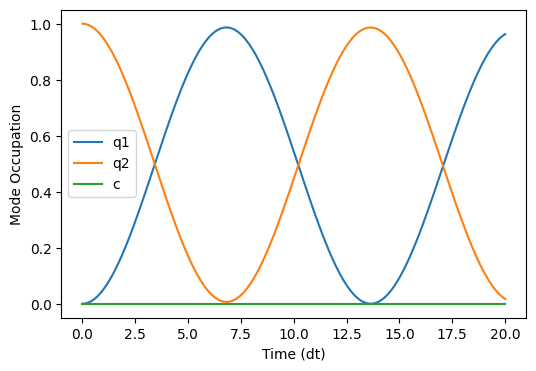

In [27]:
# Plot the state evolution (<n> vs time) for each mode (one plot total)
fig, ax = plt.subplots(figsize=(6, 4))
for k, mode in enumerate(quantum_system.modes):
    ax.plot(t_list, solve_result.expect[k], label=mode.name)
ax.set_xlabel("Time (dt)")
ax.set_ylabel("Mode Occupation")
ax.legend()
plt.show()